# Imports

In [44]:
import pandas         as pd
import numpy          as np
import seaborn        as sns

import plotly.express as px
import ipywidgets     as widgets

from ipywidgets            import fixed
from matplotlib            import pyplot as plt
from matplotlib            import gridspec
from geopy.geocoders       import Nominatim
from IPython.core.display  import HTML

# Helper Functions

In [45]:
def custom_settings():
    %matplotlib inline
        
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = (20,15)
    plt.rcParams['font.size'] = 10
        
    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.2f}'.format
    pd.set_option( 'display.expand_frame_repr', False)
    
    np.set_printoptions(suppress=True)

In [46]:
def format_numbers():
    pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [47]:
custom_settings()
format_numbers()

# Data collection

In [48]:
data = pd.read_csv('../data/kc_house_data.csv')

# Data Description

## Data Dimension

In [49]:
print('Number of rows: {}' .format (data.shape[0]))
print('Number of columns: {}' .format (data.shape[1]))

Number of rows: 21613
Number of columns: 21


## Data Types

In [50]:
data.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0    98178 47.51 -122.26           1340        5650
1  6414100192  20141209T000000 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991    98125 47.72 -122.32           1690        7639
2  5631500400  20150225T000000 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0    98028 47.74 -122.23           2720        8062
3  2487200875  20141209T000000 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0    98136 47.52 -122.39           1360        5000
4  1954400510  20150218T000000 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0    98074 47.62 -122.05           1800        7503

In [51]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## Check NA

In [52]:
data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Change variables types

In [53]:
# change 'date' type
#print(data[['date','yr_built','yr_renovated']].head(),'\n')
#print(data[['date','yr_built','yr_renovated']].dtypes)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['yr_built'] = pd.to_datetime( data['yr_built'], format='%Y')

print('\n\n----- Change -----')
print(data[['date','yr_built','yr_renovated']].dtypes)




----- Change -----
date            datetime64[ns]
yr_built        datetime64[ns]
yr_renovated             int64
dtype: object


## Droping Dupplicates

In [54]:
print(data.shape[0], ' número de linhas')
print(data['id'].unique().shape[0], ' ids únicos')
print(data.shape[0] - data['id'].unique().shape[0], ' número de ids duplicados')

21613  número de linhas
21436  ids únicos
177  número de ids duplicados


In [55]:
# sorting df by date
data = data.sort_values('date', ascending=True)

# del ids that first appear
data = data.drop_duplicates(subset='id', keep='last')

print('nova dimensão:', data.shape)

nova dimensão: (21436, 21)


In [56]:
data.to_csv('../data/dataset.csv', index=False)
data = pd.read_csv('../data/dataset.csv')

# Descriptive Statistics

In [57]:
num_attributes = data.select_dtypes(include=['int64', 'float64'])

media = pd.DataFrame(num_attributes.apply(np.mean))
mediana = pd.DataFrame(num_attributes.apply(np.median))
std = pd.DataFrame(num_attributes.apply(np.std))

max_ = pd.DataFrame(num_attributes.apply(np.max))
min_ = pd.DataFrame(num_attributes.apply(np.min))

desc = pd.concat([max_, min_, media, mediana, std], axis=1).reset_index()
desc.columns = ['attributes', 'max', 'min', 'mean', 'median', 'std']

print(desc)

       attributes           max        min          mean        median           std
0              id 9900000190.00 1000102.00 4580765328.18 3904921185.00 2876522535.73
1           price    7700000.00   75000.00     541649.96     450000.00     367306.36
2        bedrooms         33.00       0.00          3.37          3.00          0.93
3       bathrooms          8.00       0.00          2.12          2.25          0.77
4     sqft_living      13540.00     290.00       2082.70       1920.00        919.13
5        sqft_lot    1651359.00     520.00      15135.64       7614.00      41537.65
6          floors          3.50       1.00          1.50          1.50          0.54
7      waterfront          1.00       0.00          0.01          0.00          0.09
8            view          4.00       0.00          0.24          0.00          0.77
9       condition          5.00       1.00          3.41          3.00          0.65
10          grade         13.00       1.00          7.66         

## Features Creation

In [58]:
geo = pd.read_csv('../data/geolocator.csv') 

if len(geo) != (len(data) - 1):
        
    df_geo = data[['id','lat','long']].copy()
    df_geo['road'] = 'NA'
    df_geo['house_number'] = 'NA'
    df_geo['neighbourhood'] = 'NA'
    df_geo['city'] = 'NA'
    df_geo['county'] = 'NA'
    df_geo['state'] = 'NA'
    df_geo['osm'] = 'NA'
    
    print('INICIO DA COLETA')
    s = 0
    e = 2000
    
    print('NÚMERO DE LINHAS', len(df_geo))
    
    while s < len(df_geo):
        
        geolocator = Nominatim( user_agent='geoapiExercises')
        
        try:
            for i in range(s,e):

                query = str(df_geo.loc[i, 'lat']) + ',' + str(df_geo.loc[i,'long'])

                response = geolocator.reverse(query) #API Request

                #Populate data
                if 'house_number' in response.raw['address']:
                    df_geo.loc[i, 'house_number'] = response.raw['address']['house_number']

                if 'road' in response.raw['address']:
                    df_geo.loc[i, 'road'] = response.raw['address']['road']

                if 'neighbourhood' in response.raw['address']:
                    df_geo.loc[i, 'neighbourhood'] = response.raw['address']['neighbourhood']

                if 'city' in response.raw['address']:
                    df_geo.loc[i, 'city'] = response.raw['address']['city']

                if 'county' in response.raw['address']:
                    df_geo.loc[i, 'county'] = response.raw['address']['county']

                if 'state' in response.raw['address']:
                    df_geo.loc[i, 'state'] = response.raw['address']['state']

                if 'osm_type' in response.raw:
                    df_geo.loc[i, 'osm'] = response.raw['osm_type']

            print('UPDATE LINES {} | {}'.format(s,e))

            aux = df_geo
            aux.to_csv('../data/geolocator.csv', index=False, header=False)
            
            s = e
            e = e + 2000
            if e >= len(df_geo):
                e = len(df_geo)
            else:
                e = e
        
        except:
            print('ERRO NA REQUISIÇÃO')
        
    print('FIM DA COLETA')
    
    cols_name = ['id','lat','long','road','house_number','neighbourhood','city','county','state','osm']
    
    df_geo = pd.read_csv('../data/geolocator.csv',names=cols_name)
    df_geo = df_geo.drop(columns=['lat', 'long'])
    
    data = pd.merge(data, df_geo, how='left', on='id')

else:
    print('DATASET ATUALIZADO')
    
    cols_name = ['id','lat','long','road','house_number','neighbourhood','city','country','state','osm']
    df_geo = pd.read_csv('../data/geolocator.csv',names=cols_name)
    df_geo = df_geo.drop(columns=['lat', 'long'])
    
    data = pd.merge(data, df_geo, how='left', on='id')    

DATASET ATUALIZADO


In [59]:
data['dormitory_type'] = 'type'
data.loc[data['bedrooms'] <= 1, 'dormitory_type'] = 'studio'
data.loc[data['bedrooms'] == 2, 'dormitory_type'] = 'apartament'
data.loc[data['bedrooms'] >= 3, 'dormitory_type'] = 'house'

In [60]:
# media de preço por zipcode

# create media
temp = data[['price','zipcode']].groupby('zipcode').median().reset_index().rename(columns={'price': 'median_price'})
temp.head()

# merge on dataset
data = pd.merge(data, temp, on='zipcode', how='left')
data[['id', 'price', 'zipcode', 'median_price']].sample(5)


id     price  zipcode  median_price
9864   2597490030 815000.00    98029     574500.00
18482  3521069146 485000.00    98022     279500.00
17392   945000410 265000.00    98117     545000.00
15022  2600010330 760000.00    98006     760184.50
16265  7611200195 709000.00    98177     557000.00

In [61]:
# buying decision
# as variaveis levadas em conta são média de preço da região e a condição
data['decision'] = data[['price', 'median_price', 'condition']].apply(lambda x: 1 if ((x['price'] <= x['median_price']) & (x['condition']>=3)) else 0, axis=1) 
data[['id', 'zipcode', 'price', 'median_price', 'condition', 'decision']].sample(5)

id  zipcode     price  median_price  condition  decision
3967   6003500749    98122 640000.00     574000.00          3         0
5330   8682301910    98053 389000.00     635000.00          3         1
20601   537000416    98003 250000.00     269500.00          4         1
411       1200019    98166 647500.00     392500.00          4         0
20810  8644210110    98075 792000.00     739999.50          3         0

In [62]:
# selling price suggestion
data['selling_suggestion'] = data[['price', 'median_price', 'condition']].apply(lambda x: x['price']*1.25
                                                                    if ((x['price'] <= x['median_price']) & (x['condition']>=3)) else 0, axis=1)

data[['id', 'zipcode', 'price', 'median_price', 'condition', 'decision', 'selling_suggestion']].sample(5)


id  zipcode     price  median_price  condition  decision  selling_suggestion
19372  2822059181    98030 306000.00     283000.00          3         0                0.00
8226   8732020770    98023 263850.00     269000.00          4         1           329812.50
16837  1623049062    98168 210000.00     237000.00          3         1           262500.00
7636   1180002075    98178 235000.00     279500.00          3         1           293750.00
5917   4046500160    98014 441000.00     415000.00          3         0                0.00

In [63]:
# expected profit
data['expected_profit'] = data[['price', 'selling_suggestion']].apply(lambda x: 0 if x['selling_suggestion']==0
                                                                                        else (x['selling_suggestion'] - x['price']), axis=1) 

data[['id', 'zipcode', 'price', 'median_price', 'condition', 'decision', 'selling_suggestion', 'expected_profit']].sample(5)

id  zipcode     price  median_price  condition  decision  selling_suggestion  expected_profit
19391  2624039114    98136 360000.00     489950.00          3         1           450000.00         90000.00
1286   6372000060    98116 662990.00     565500.00          5         0                0.00             0.00
16224  2337000150    98023 230000.00     269000.00          3         1           287500.00         57500.00
11963  1560920370    98038 485000.00     342500.00          3         0                0.00             0.00
4710   9285800755    98126 515000.00     396587.50          3         0                0.00             0.00

In [64]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
# seasons of the year
def date_season(date):
    
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'fall': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['fall']:
        return 'fall'
    else:
        return 'winter'

data['season'] = data['date'].map(date_season)
data[['date','season']].head()

date  season
0 2014-05-02  spring
1 2014-05-02  spring
2 2014-05-02  spring
3 2014-05-02  spring
4 2014-05-02  spring

In [65]:
# median price per season and zipcode

# grouping by zipcode and median price by season
aux = data[['price','zipcode','season']].groupby(['zipcode', 'season']).median().reset_index()

aux1 = aux.pivot(index='zipcode', columns='season', values='price').reset_index()
aux1 = aux1.rename(columns={'fall':'med_fall', 'spring':'med_spring', 'summer':'med_summer', 'winter':'med_winter'})

# merge
data = pd.merge(data, aux1, on='zipcode', how='left')

# sample
data[['id', 'price', 'zipcode', 'median_price', 'med_fall', 'med_spring', 'med_summer', 'med_winter']].sample(5)

id      price  zipcode  median_price  med_fall  med_spring  med_summer  med_winter
18022  6413600276  354950.00    98125     425000.00 435500.00   429975.00   420000.00   425000.00
8411   2937300440  923990.00    98052     615000.00 600000.00   625000.00   620000.00   602000.00
17586  5196420290  940000.00    98052     615000.00 600000.00   625000.00   620000.00   602000.00
11874  8682262260  515000.00    98053     635000.00 666000.00   666000.00   652500.00   569000.00
20726  3125079013 1065000.00    98024     462500.00 427500.00   589000.00   529000.00   381000.00

In [66]:
# Best season to sell

data['season_sell'] = ''

# defining best season to sell accorgding to avg price for each season
for i in range (len(data)):
    cols = ['med_fall', 'med_spring', 'med_summer', 'med_winter']
    
    if data.loc[i, 'decision']!=0:
    
        if data.loc[i, cols[0]] >= data.loc[i,'price']:
            data.loc[i, 'season_sell'] = data.loc[i, 'season_sell'] + 'autumn '
        if data.loc[i, cols[1]] >= data.loc[i,'price']:
            data.loc[i, 'season_sell'] = data.loc[i, 'season_sell'] + 'spring '
        if data.loc[i, cols[2]] >= data.loc[i,'price']:
            data.loc[i, 'season_sell'] = data.loc[i, 'season_sell'] + 'summer '
        if data.loc[i, cols[3]] >= data.loc[i,'price']:
            data.loc[i, 'season_sell'] = data.loc[i, 'season_sell'] + 'winter '

data[['id', 'price', 'zipcode', 'median_price', 'med_fall', 'med_spring', 'med_summer', 'med_winter', 'decision', 'season_sell']].head()

id     price  zipcode  median_price  med_fall  med_spring  med_summer  med_winter  decision                   season_sell
0  5561000190 437500.00    98027     571000.00 545000.00   574950.00   575000.00   538100.00         1  autumn spring summer winter 
1   472000620 790000.00    98117     545000.00 535000.00   544000.00   545000.00   554500.00         0                              
2  1024069009 675000.00    98029     574500.00 575000.00   592500.00   561000.00   555000.00         0                              
3  7853361370 555000.00    98065     500000.00 452250.00   516000.00   485000.00   520000.00         0                              
4  5056500260 440000.00    98006     760184.50 760369.00   760000.00   758000.00   791270.50         1  autumn spring summer winter

# Data exploration

# E D A

## Análise Univariada

### Variável de resposta: lucro esperado

In [67]:
aux = data[data['expected_profit']!= 0][['id', 'expected_profit']].copy()

bin_groups = list(np.arange(0,635000,5000))
aux['var_expected_profit'] = pd.cut(aux['expected_profit'], bins=bin_groups)

aux.head()

id  expected_profit var_expected_profit
0  5561000190        109375.00    (105000, 110000]
4  5056500260        110000.00    (105000, 110000]
5  3438501320         73750.00      (70000, 75000]
6  1737320120        117500.00    (115000, 120000]
7  7197300105        137500.00    (135000, 140000]

In [68]:
# grouping in bins the number of properties ('id_') and sum of 'expected_profit'
aux1 = ( aux.groupby('var_expected_profit').agg(properties = ('id', 'count'),
                                                expected_profit = ('expected_profit', 'sum')) ).reset_index()

aux1.head()

var_expected_profit  properties  expected_profit
0           (0, 5000]           0             0.00
1       (5000, 10000]           0             0.00
2      (10000, 15000]           0             0.00
3      (15000, 20000]           1         18750.00
4      (20000, 25000]          18        416987.50

In [69]:
# sorting by number of 'id_'
aux1.sort_values('properties', ascending=False).head()

var_expected_profit  properties  expected_profit
12      (60000, 65000]         742      46669480.25
13      (65000, 70000]         650      44107183.25
11      (55000, 60000]         613      35497112.25
14      (70000, 75000]         543      39663712.00
16      (80000, 85000]         536      44388170.75

In [70]:
aux1.sort_values('expected_profit', ascending=False).head()

var_expected_profit  properties  expected_profit
21    (105000, 110000]         494      53331741.25
24    (120000, 125000]         396      48786970.75
26    (130000, 135000]         359      47646587.75
19     (95000, 100000]         484      47498632.75
12      (60000, 65000]         742      46669480.25

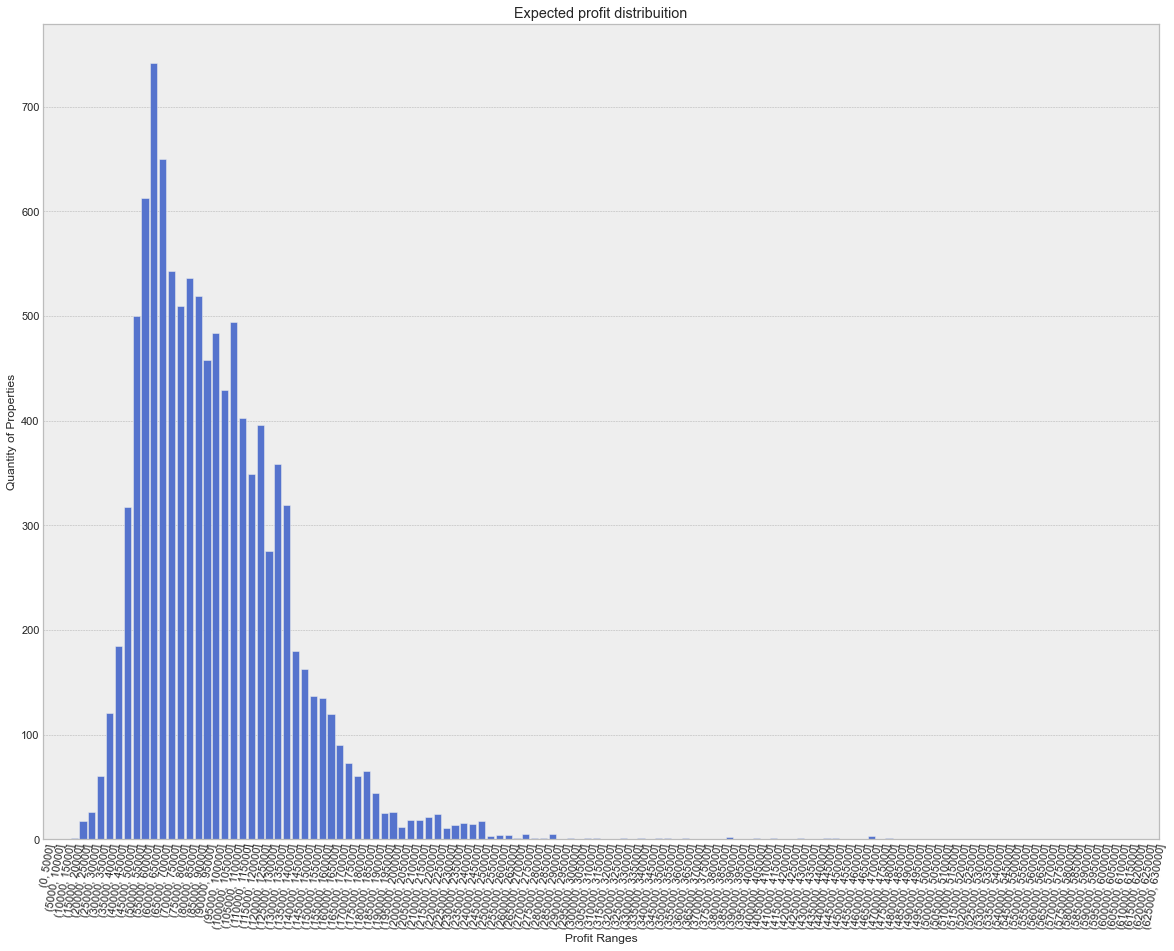

In [71]:
# properties distribution

p = sns.barplot(data=aux1, x='var_expected_profit', y='properties',color='royalblue')
p.set_title('Expected profit distribuition')
p.set_xlabel('Profit Ranges')
p.set_ylabel('Quantity of Properties')
plt.xticks(rotation=80);

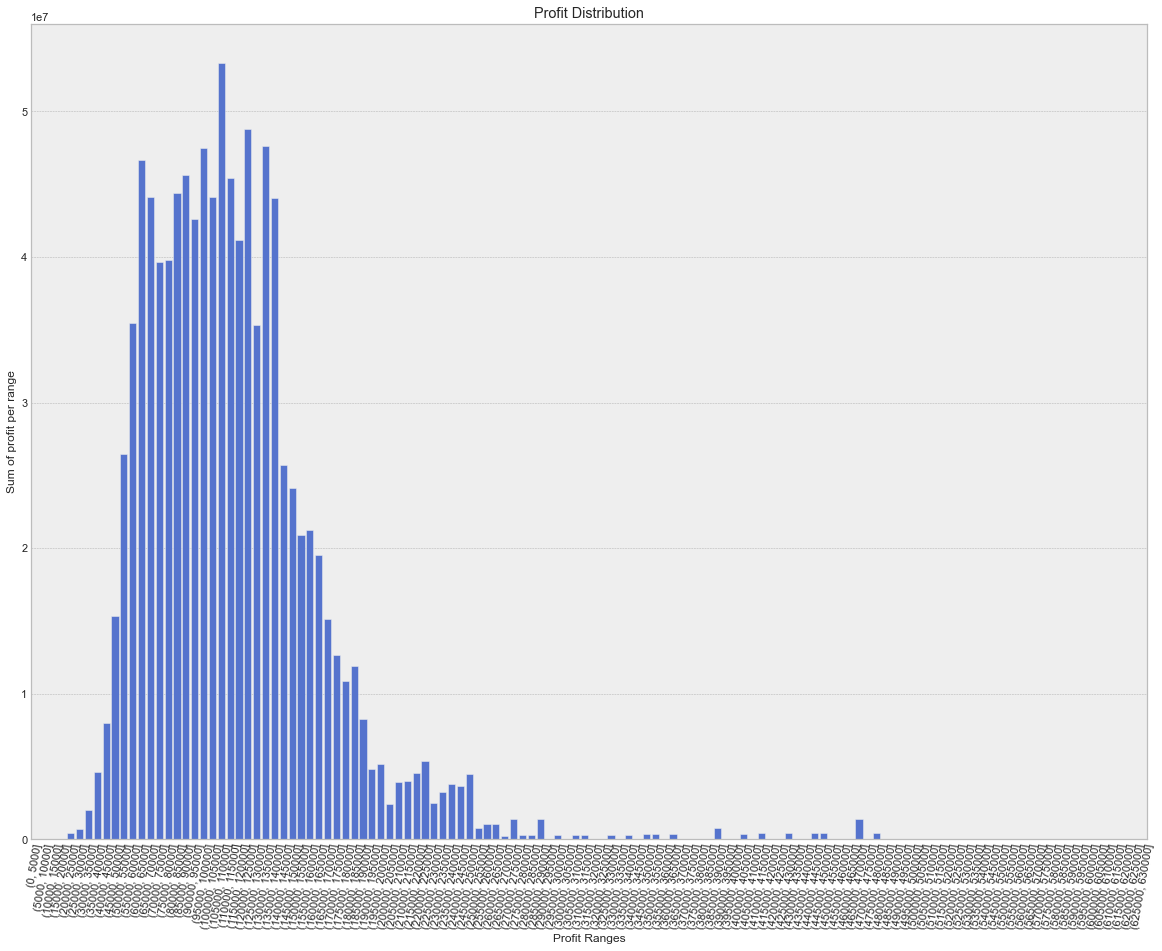

In [72]:
# profit_distribution
p = sns.barplot(data=aux1, x='var_expected_profit', y='expected_profit', color='royalblue');
p.set_title('Profit Distribution')
p.set_xlabel('Profit Ranges')
p.set_ylabel('Sum of profit per range')
plt.xticks(rotation=80);

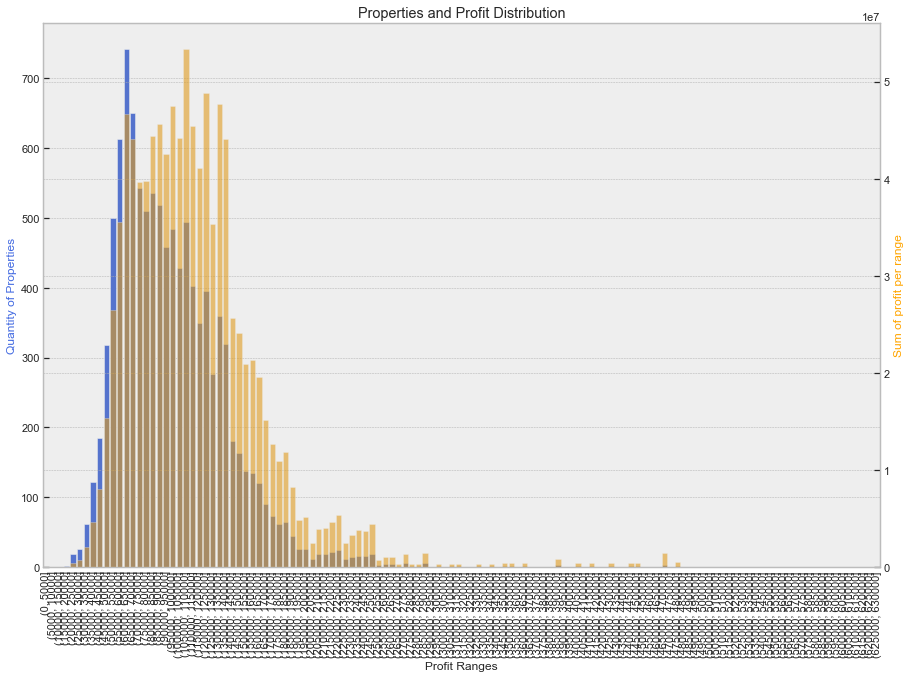

In [73]:
# creating comparision plot area
fig, ax1 = plt.subplots(figsize=(15,10))

# setting first graph - properties distribution
ax1 = sns.barplot(data=aux1, x='var_expected_profit', y='properties', color='royalblue', alpha=1)
ax1.set_title('Properties and Profit Distribution')
ax1.set_xticklabels(aux1['var_expected_profit'], rotation=90);
ax1.set_xlabel('Profit Ranges')
ax1.set_ylabel('Quantity of Properties', color='royalblue')
ax1.tick_params(axis='y')

# setting to share x-axis
ax2 = ax1.twinx()

# creating second graph - profit distribution
ax2 = sns.barplot(data=aux1, x='var_expected_profit', y='expected_profit', color='orange', alpha=0.6)
ax2.set_ylabel('Sum of profit per range', color='orange')
ax2.tick_params(axis='y')

# showing plot
plt.show()

## Variáveis numéricas

In [74]:
v_num = data.select_dtypes(include=['int64','float64'])
v_cat = data.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

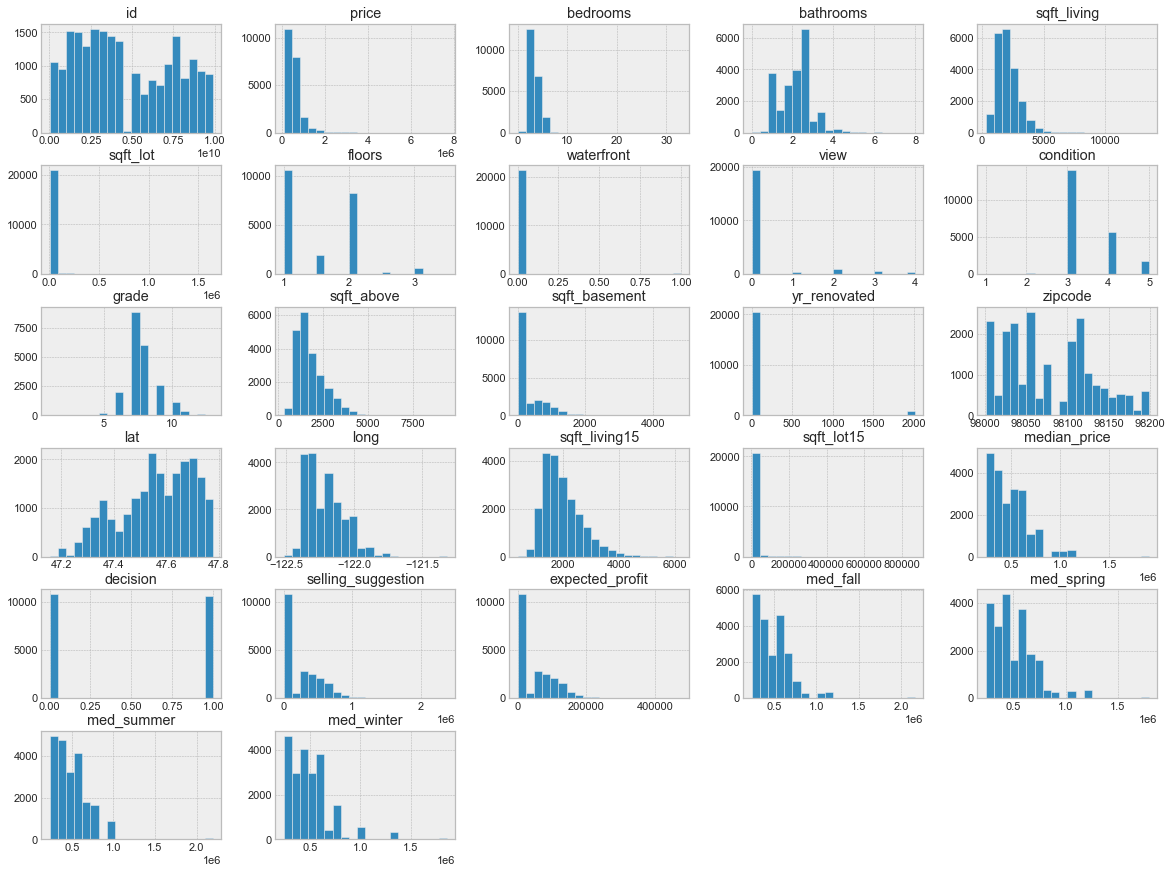

In [75]:
v_num.hist(bins=20);
sns.set_theme(style ='darkgrid')

## Variáveis categóricas

In [76]:
print(v_cat.dtypes)
v_cat.head()

yr_built          object
road              object
house_number      object
neighbourhood     object
city              object
country           object
state             object
osm               object
dormitory_type    object
season            object
season_sell       object
dtype: object


yr_built                      road house_number neighbourhood      city        country       state  osm dormitory_type  season                   season_sell
0  1977-01-01    Southeast 154th Street        26069           NaN       NaN  United States  Washington  way          house  spring  autumn spring summer winter 
1  1951-01-01     34th Avenue Northwest         7506   Sunset Hill   Seattle  United States  Washington  way          house  spring                              
2  1979-01-01        Southeast 32nd Way        23601           NaN       NaN  United States  Washington  way          house  spring                              
3  2012-01-01  Southeast Terrace Street        35246           NaN       NaN  United States  Washington  way          house  spring                              
4  1966-01-01     Southeast 65th Street        12201           NaN  Bellevue  United States  Washington  way          house  spring  autumn spring summer winter

In [77]:
v_cat.isna().sum()

yr_built              0
road                227
house_number       1226
neighbourhood     14246
city              12466
country              10
state                10
osm                  10
dormitory_type        0
season                0
season_sell           0
dtype: int64

### County

### City

In [78]:
endereco = data[['id', 'zipcode', 'road', 'house_number', 'neighbourhood', 'city', 'country', 'state']].copy()

print('Dados: ', endereco['city'].unique())
print('NA: ', endereco['city'].isna().sum())

Dados:  [nan 'Seattle' 'Bellevue' 'Shoreline' 'Kent' 'King County']
NA:  12466


In [79]:
endereco[['id','city']].groupby('city').count().sort_values('id',ascending=False).reset_index()

city    id
0      Seattle  7028
1     Bellevue  1316
2    Shoreline   619
3         Kent     5
4  King County     2

✔️ Seattle, Bellevue, Shoreline, Kent pertencem ao condado de County<br>
❌ King Count é um erro<br>

fonte: https://kingcounty.gov/depts/health/codes/cities.aspx 

### Investigating King County city

In [41]:
endereco[endereco['city'] == 'King County']

id  zipcode                road house_number neighbourhood         city        country       state
11552  8075400570    98032  South 239th Street         3704        Midway  King County  United States  Washington
14453  8075400100    98032   41st Avenue South        23654           NaN  King County  United States  Washington

✔️ O zipcode 98032 pertence a cidade de Kent<br>

fonte: https://wa.postcodebase.com/zipcode5/98032

In [81]:
# verificação de quantos imóveis '98032' são 'NaN' em 'city'
data[data['zipcode']==98032][['city']].isna().sum()[0]

118

#### Inputing 'Kent' as city to 98032 'zipcode'

In [82]:
# verificação de quantos imóveis '98032' são 'Kent' e 'King County' em 'city'
data[data['zipcode']==98032][['zipcode','city']].groupby('city').count().reset_index()

city  zipcode
0         Kent        3
1  King County        2

In [85]:
# substituição dos valores de 'city' por 'Kent' com o código postal '98032'
data['city'] = data.apply(lambda x: 'Kent' if x['zipcode'] == 98032 else x['city'], axis=1)

data[data['zipcode']==98032][['zipcode','city']].groupby('city').count().reset_index()

city  zipcode
0  Kent      123

### Investigating 'city' NA

In [84]:
endereco = data[['id', 'zipcode', 'road', 'house_number', 'neighbourhood', 'city', 'country', 'state']].copy()

print('NA: ', endereco['city'].isna().sum())
endereco[endereco['city'].isna()].head()

NA:  12348


id  zipcode                      road house_number neighbourhood city        country       state
0  5561000190    98027    Southeast 154th Street        26069           NaN  NaN  United States  Washington
2  1024069009    98029        Southeast 32nd Way        23601           NaN  NaN  United States  Washington
3  7853361370    98065  Southeast Terrace Street        35246           NaN  NaN  United States  Washington
6  1737320120    98011    Northeast 195th Street         8915           NaN  NaN  United States  Washington
7  7197300105    98052    170th Avenue Northeast         9105           NaN  NaN  United States  Washington

In [87]:
# Contagem de quantas 'city' e 'neighourhood' são 'NA'
print(endereco[(endereco['city'].isna()) & (endereco['neighbourhood'].isna())].shape[0], 'city e neighbourhood são NA')
print(endereco[(endereco['city'].isna()) & (~endereco['neighbourhood'].isna())].shape[0], 'city NA e neighbourhood está preenchido')

9042 city e neighbourhood são NA
3306 city NA e neighbourhood está preenchido


In [89]:
# Contagem de quantos 'zipcode' estão NA em 'city'
print("número de zipcode com NA para 'city':", endereco[endereco['city'].isna()][['zipcode', 'city']].groupby('zipcode').count().reset_index().shape[0])
endereco[endereco['city'].isna()][['zipcode', 'city']].groupby('zipcode').count().reset_index().sample(5)

número de zipcode com NA para 'city': 52


zipcode  city
33    98070     0
39    98106     0
40    98119     0
7     98010     0
6     98008     0

## Hypothesis creation

### 1- Propriedades com vista para o mar são 40% mais caras.
**Falso:** Propriedades com vista para água tem um valor 211.76% mais caras.

In [133]:
aux = data[['waterfront', 'price']].groupby('waterfront').mean().reset_index()

not_waterfront = aux.iloc[0,1]
yes_waterfront = aux.iloc[1,1]

percent = abs( ((yes_waterfront - not_waterfront) / not_waterfront)*100 )
print('\nPropriedades com vista para água são', '{:,.2f}'.format(percent),'% mais caras')


Propriedades com vista para água são 211.76 % mais caras


### 2- As propriedades com porão têm um estado de conservação melhor.
**Verdade:** Propriedades com porões tem qualidade ligeiramente superior.

<BarContainer object of 5 artists>

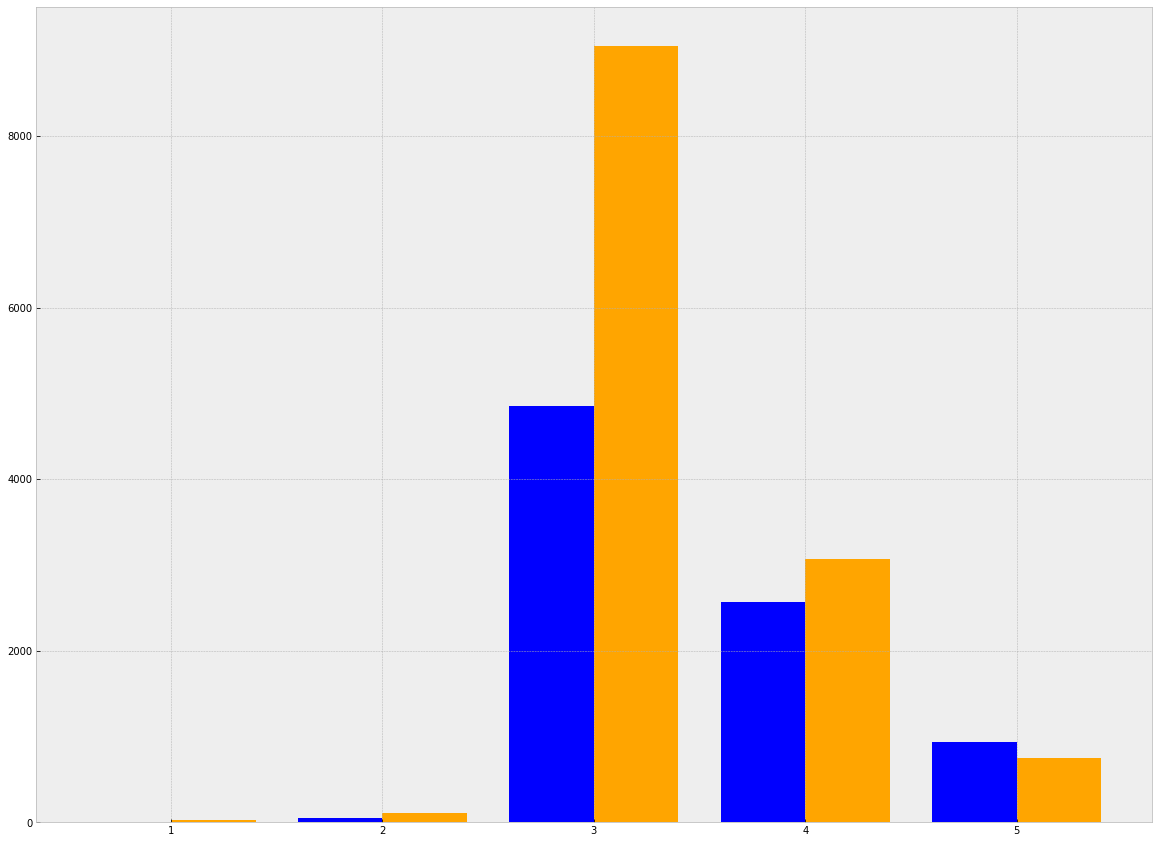

In [177]:
# Propriedades com porão
aux1 = data[data['sqft_basement']!=0][['id','condition','sqft_basement']].copy()
y_porao = aux1[['id','condition']].groupby('condition').count().reset_index()

# Propriedades sem porão
aux2 = data[data['sqft_basement']==0][['id','condition','sqft_basement']].copy()
n_porao = aux2[['id','condition']].groupby('condition').count().reset_index()

#width = 0.40
plt.bar(y_porao['condition']-0.2, y_porao['id'], width, color='blue', label='Possui porão')
plt.bar(n_porao['condition']+0.2, n_porao['id'], width, color='orange', label='Não possui porão')

In [135]:
# nota média ponderada
avg_yporao = np.average(np.array(y_porao['condition']), weights=np.array(y_porao['id']))
print('Nota média ponderada para propriedades com porão: {:,.2f}'.format(avg_yporao))

avg_nporao = np.average(np.array(n_porao['condition']), weights=np.array(n_porao['id']))
print('Nota média ponderada para propriedades sem porão: {:,.2f}'.format(avg_nporao))

print('\nPequena diferença na qualidade para propriedades com porão.')

Nota média ponderada para propriedades com porão: 3.52
Nota média ponderada para propriedades sem porão: 3.34

Pequena diferença na qualidade para propriedades com porão.


### 3- Imóveis com porão têm maior espaço interior.
**Verdade:** As propriedades com porão têm, em média um espaço 19.83% maior.

In [136]:
y_porao = data[data['sqft_basement']!=0][['sqft_living']].mean()[0]
n_porao = data[data['sqft_basement']==0][['sqft_living']].mean()[0]

print('Média de espaço interior de imóveis com porão: {:,.2f}'.format(y_porao))
print('Média de espaço interior de imóveis sem porão: {:,.2f}'.format(n_porao))

percent = abs( ((y_porao - n_porao) / n_porao)*100 )
print('\nImóveis com porão tem em média um espaço ', '{:,.2f}'.format(percent),'% maior.')

Média de espaço interior de imóveis com porão: 2,315.30
Média de espaço interior de imóveis sem porão: 1,932.21

Imóveis com porão tem em média um espaço  19.83 % maior.


### 4- Imóveis com porão são 15% mais caros.
**Falso:** Imóveis com porão são em média 27,84% mais caros.

In [137]:
y_porao = data[data['sqft_basement']!=0][['price']].mean()[0]
print('Average price of properties with basement: {:,.2f}'.format(y_porao))

n_porao = data[data['sqft_basement']==0][['price']].mean()[0]
print('Average price of properties without basement: {:,.2f}'.format(n_porao))

percent = abs( ((y_porao - n_porao) / n_porao)*100 )
print('Properties with basement are', '{:,.2f}'.format(percent),'% more expensive.')

Average price of properties with basement: 623,967.32
Average price of properties without basement: 488,388.76
Properties with basement are 27.76 % more expensive.


### 5- Propriedades construídas com porões diminuíram ao longo dos anos.
**Verdade:** Propriedades construídas com subsolos começaram a ter uma diminuição acentuada no fim dos anos 70.

In [138]:
data['yr_built'] = pd.to_datetime(data['yr_built']).dt.strftime('%Y')

total = data[['id', 'yr_built']].groupby('yr_built').count().reset_index()
total.head()

yr_built  id
0     1900  86
1     1901  29
2     1902  27
3     1903  45
4     1904  44

In [139]:
y_porao = data[data['sqft_basement']!=0][['sqft_basement','yr_built']].groupby('yr_built').count().reset_index()
y_porao.head()

yr_built  sqft_basement
0     1900             29
1     1901             11
2     1902              5
3     1903             10
4     1904             20

In [140]:
compara = pd.merge(total, y_porao, on='yr_built', how='left').rename(columns={'id': 'properties', 'sqft_basement': 'y_porao'})
compara['n_porao'] = compara['properties'] - compara['y_porao']
compara.head()

yr_built  properties  y_porao  n_porao
0     1900          86       29       57
1     1901          29       11       18
2     1902          27        5       22
3     1903          45       10       35
4     1904          44       20       24

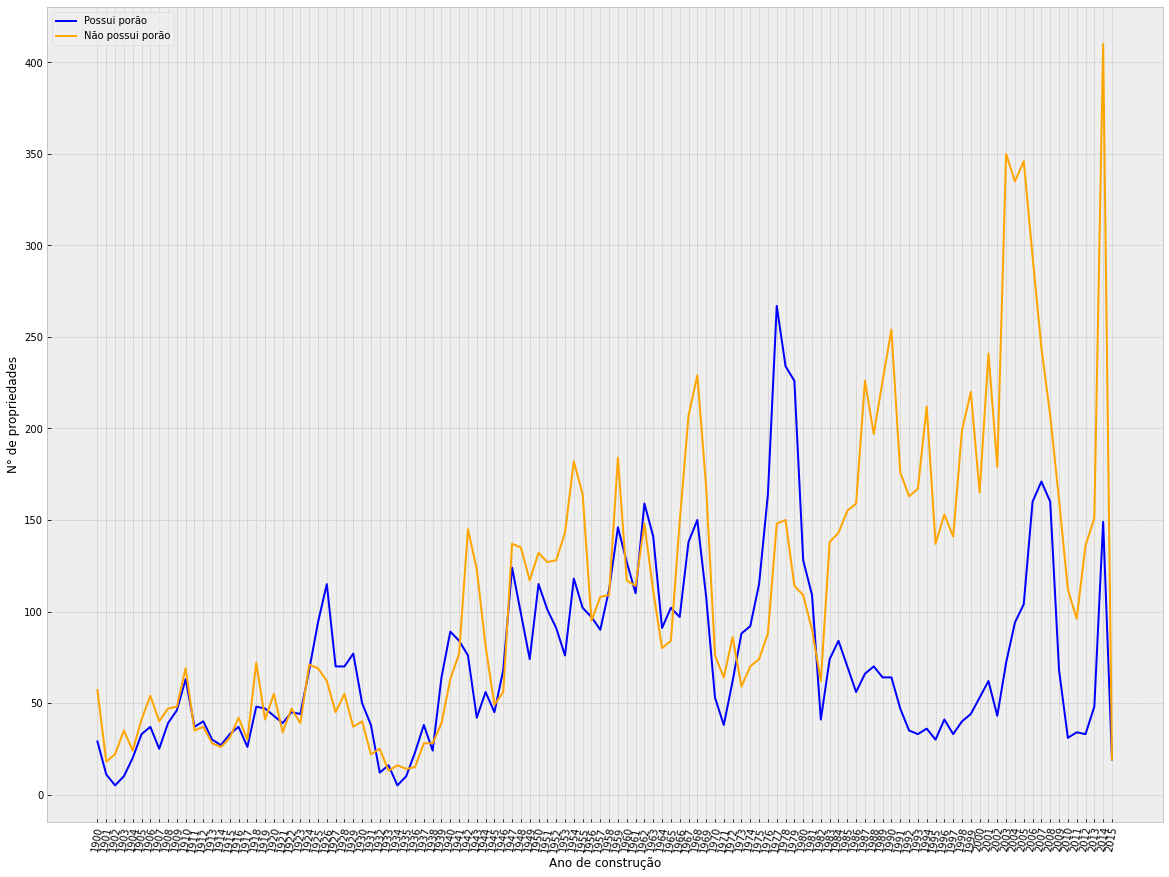

In [141]:
plt.xticks( rotation=80)
plt.plot(compara['yr_built'], compara['y_porao'], color='blue', label='Possui porão')
plt.plot(compara['yr_built'], compara['n_porao'], color='orange', label='Não possui porão')
plt.xlabel('Ano de construção')
plt.ylabel('N° de propriedades')
plt.legend()
plt.show()

### 6 - Imóveis com 2 banheiros são 20% mais caros do que imóveis com até 1 banheiro.
**Falso:** Imóveis com 2 banheiros são 37,99% mais caros do que aqueles com até 1 banheiro.

In [142]:
aux = data[['id', 'bathrooms', 'price']].copy()

aux1 = (aux.groupby('bathrooms').agg(properties = ('id', 'count'),
                                avg_price  = ('price', 'mean'))).reset_index()

aux2 = aux1[aux1['bathrooms']<=1]
aux2_mean = aux2['avg_price'].mean()
print('Preço médio de imóveis com até 1 banheiro: {:,.2f}'.format(aux2_mean))

aux3 = aux1[(aux1['bathrooms']==2)]
aux3_mean = aux3['avg_price'].mean()
print('Preço médio de imóveis com 2 banheiros: {:,.2f}'.format(aux3_mean))

percent = abs( ((aux3_mean - aux2_mean) / aux2_mean)*100 )
print('Imóveis com 2 banheiros são', '{:,.2f}'.format(percent),'% mais caros.')

Preço médio de imóveis com até 1 banheiro: 332,861.36
Preço médio de imóveis com 2 banheiros: 459,307.01
Imóveis com 2 banheiros são 37.99 % mais caros.


### 7- Propriedades com 3 quartos são 30% mais caras do que aquelas com 2 quartos.
** Falso: ** Imóveis com 3 quartos são 25,24% mais caros do que aqueles com 2 quartos.

In [143]:
aux = data[['id', 'bedrooms', 'price']].copy()

aux1 = (aux.groupby('bedrooms').agg(properties = ('id', 'count'),
                               avg_price  = ('price', 'mean'))).reset_index()

aux2 = aux1.iloc[1,2]
aux3 = aux1.iloc[2,2]

print('Preço médio de imóveis com 2 quartos: {:,.2f}'.format(aux2))
print('Preço médio de imóveis com 3 quartos: {:,.2f}'.format(aux3))

percentage = abs( ((aux3 - aux2) / aux2)*100 )
print('Properties with 3 bedrooms are ', '{:,.2f}'.format(percentage),'% more expensive than those which have 2 bedrooms.')

Preço médio de imóveis com 2 quartos: 321,180.07
Preço médio de imóveis com 3 quartos: 402,230.37
Properties with 3 bedrooms are  25.24 % more expensive than those which have 2 bedrooms.


### 8- Imóveis reformados são 30% mais caros.
**Falso:** Imóveis reformados são 17,80% mais caros do que os não reformados.

In [144]:
# imóveis reformados são 30% mais caros

aux = data[['id', 'yr_renovated', 'price']].copy()

aux1 = (aux.groupby('yr_renovated').agg(properties = ('id', 'count'),
                                    avg_price  = ('price', 'mean'))).reset_index()

aux2 = aux1[aux1['yr_renovated'] > 0 ]
aux2_mean = aux2['avg_price'].mean()
print('Média de preço de imóveis reformados: {:,.2f}'.format(aux2_mean))

aux3 = aux1[aux1['yr_renovated'] == 0 ]
aux3_mean = aux3['avg_price'].mean()
print('Média de preço de imóveis sem reformas: {:,.2f}'.format(aux3_mean))

percentage = abs( ((aux3_mean - aux2_mean) / aux2_mean)*100 )
print('Imóveis reformados são ', '{:,.2f}'.format(percentage),'% mais caros.')

Média de preço de imóveis reformados: 647,088.46
Média de preço de imóveis sem reformas: 531,875.73
Imóveis reformados são  17.80 % mais caros.


### 9- Imóveis reformados tem uma avaliação 20% maior
**Falso:** Imóveis reformados tem uma avaliação 4.28% maior que imóveis não reformados.

In [179]:
aux = data[['id', 'yr_renovated', 'grade']].copy()

aux1 = (aux.groupby('yr_renovated').agg(properties = ('id', 'count'),
                                    avg_grade  = ('grade', 'mean'))).reset_index()

aux2 = aux1[aux1['yr_renovated'] > 0 ]
aux2_mean = aux2['avg_grade'].mean()
print('Média de preço de imóveis reformados: {:,.2f}'.format(aux2_mean))

aux3 = aux1[aux1['yr_renovated'] == 0 ]
aux3_mean = aux3['avg_grade'].mean()
print('Média de preço de imóveis sem reformas: {:,.2f}'.format(aux3_mean))

percentage = abs( ((aux3_mean - aux2_mean) / aux2_mean)*100 )
print('Imóveis reformados tem uma avalição ', '{:,.2f}'.format(percentage),'% maior.')

Média de preço de imóveis reformados: 7.34
Média de preço de imóveis sem reformas: 7.66
Imóveis reformados tem uma avalição  4.28 % maior.


### 10- Studios são 40% mais baratos que apartamentos
** Falso: ** Studios são 25.24 % mais baratos do que apartamentos.

In [146]:
aux = data[['id', 'dormitory_type', 'price']].copy()

aux1 = (aux.groupby('dormitory_type').agg(properties = ('id', 'count'),
                                     avg_price  = ('price', 'mean'))).reset_index()

f1 = aux1[aux1['dormitory_type'] == 'studio']
f1_mean = f1['avg_price'].mean()
print('Preço médio de studios: {:,.2f}'.format(f1_mean))

f2= aux1[aux1['dormitory_type']== 'apartament']
f2_mean = f2['avg_price'].mean()
print('Preço médio de apartamentos: {:,.2f}'.format(f2_mean))

percentage = abs( ((f2_mean - f1_mean) / f1_mean)*100 )
print('Studios são {:,.2f}'.format(percentage),'% mais baratos do que apartamentos.')

Preço médio de studios: 326,726.98
Preço médio de apartamentos: 402,230.37
Studios são 23.11 % mais baratos do que apartamentos.


### 11- A maioria das propriedades (+ 50%) ficou disponível durante o verão / primavera.
** Verdadeiro: ** Aproximandamente 60% das propriedades ficaram disponíveis durante o verão / primavera.

In [169]:
season = data[['season', 'id']].copy()

season['SS_FW'] = season.apply(lambda x: 'SS' if x['season']=='summer' 
                          else 'SS' if x['season']=='spring' 
                          else 'FW', axis=1)


disp = season[['SS_FW', 'id']].groupby('SS_FW').count().sort_values('id', ascending=False).reset_index()
disp['%'] = disp['id']/disp['id'].sum()*100
disp.head()

SS_FW     id     %
0    SS  12847 59.93
1    FW   8589 40.07

### 12- Imóveis disponíveis durante o verão / primavera são 20% mais caros.
** Falso: ** Os imóveis disponíveis no verão / primavera são 4,5% mais caros.

In [148]:
aux = data[['id', 'season', 'price']].copy()

aux['SS_AW'] = aux.apply(lambda x: 'SS' if x['season']=='summer' 
                          else 'SS' if x['season']=='spring' 
                          else 'AW', axis=1)

valor = (aux.groupby('SS_AW').agg(properties   = ('id', 'count'),
                            price_min    = ('price', 'min'),
                            price_max    = ('price', 'max'),
                            price_median = ('price', 'median'),
                            price_mean   = ('price', 'mean')) ).sort_values('price_mean', ascending=False).reset_index()

SS_mean = valor.iloc[0,5]
FW_mean = valor.iloc[1,5]

percent = abs( ((SS_mean - FW_mean) / FW_mean)*100 )
print('Imóveis disponíveis durante a primavera ou verão são ', '{:,.2f}'.format(percent),'% mais caros.')

valor.head()

Imóveis disponíveis durante a primavera ou verão são  4.50 % mais caros.


SS_AW  properties  price_min  price_max  price_median  price_mean
0    SS       12847   78000.00 7062500.00     463000.00   551150.93
1    AW        8589   75000.00 7700000.00     437500.00   527438.88

### 13- A maioria das propriedades (+ 50%) que devem ser compradas são apartamentos.
** Falso: ** Apartamentos representam 12.76% dos imóveis qualificados para compra.

In [161]:
# distribuição de casas disponiveis para venda

auxb = data[['id', 'dormitory_type']].copy()
auxb = auxb[['dormitory_type', 'id']].groupby('dormitory_type').count().sort_values('id', ascending=False).reset_index()
auxb['%'] = (auxb['id']/auxb['id'].sum()) * 100

auxb.head()

dormitory_type     id     %
0          house  18493 86.27
1     apartament   2736 12.76
2         studio    207  0.97

<BarContainer object of 3 artists>

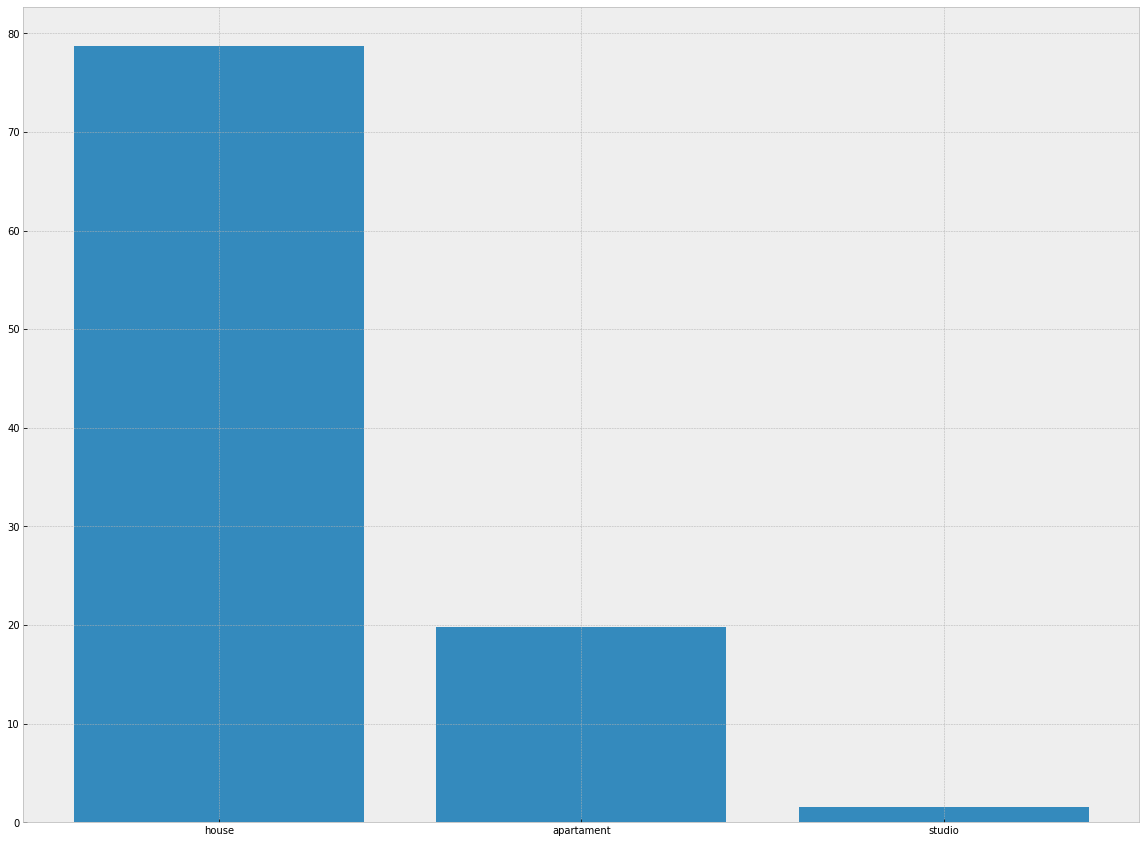

In [163]:
aux = data[data['decision']!=0][['id', 'dormitory_type', 'decision']].copy()

aux1 = aux[['dormitory_type', 'decision']].groupby('dormitory_type').count().sort_values('decision', ascending=False).reset_index()
aux1['%'] = (aux1['decision']/aux1['decision'].sum()) * 100

aux1.head()
plt.bar(aux1['dormitory_type'], aux1['%'])

### 14- Os imóveis tem maior espaço interior ao longo dos anos de construção.
** Verdadeiro: ** As propriedades têm maior espaço interior ao longo dos anos de construção.

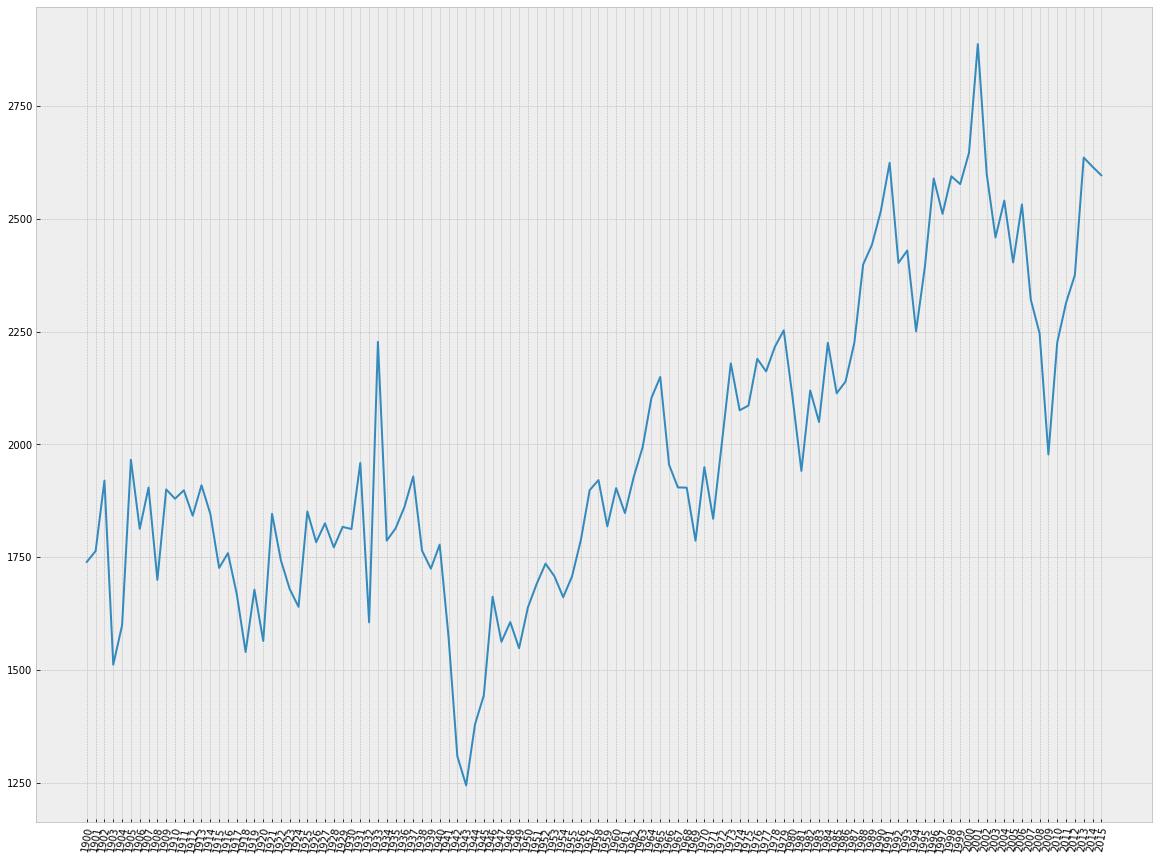

In [150]:
aux = data[['sqft_living', 'yr_built']].copy()

aux1 = aux.groupby('yr_built').mean().reset_index()

plt.xticks( rotation=80)
plt.plot(aux1['yr_built'], aux1['sqft_living'])
plt.show()

### 15- As propriedades selecionadas para compra com vista para a água correspondem 25% do lucro esperado.
** Falso: ** As propriedades selecionadas para compra com vistá para água representam menos de 1% do lucro esperado.

In [183]:
# casas qualificadas para compra com vista para a água

aux = data[data['decision']!=0][['id', 'waterfront']].copy()
aux = aux[['waterfront', 'id']].groupby('waterfront').count().sort_values('id', ascending=False).reset_index()

aux.head()

waterfront     id
0           0  10632
1           1     10

In [184]:
aux = data[data['expected_profit']!=0][['id', 'waterfront', 'expected_profit']].copy()

aux1 = ( aux[['waterfront', 'expected_profit']].groupby('waterfront').agg(profit_min    = ('expected_profit', 'min'),
                                                                          profit_max    = ('expected_profit', 'max'),
                                                                          profit_median = ('expected_profit', 'median'),
                                                                          profit_mean   = ('expected_profit', 'mean'),
                                                                          profit_sum    = ('expected_profit', 'sum'),) ).reset_index()

aux1['%'] = (aux1['profit_sum']/aux1['profit_sum'].sum()) * 100

aux1.head()

waterfront  profit_min  profit_max  profit_median  profit_mean    profit_sum     %
0           0    18750.00   476250.00       90000.00     97312.66 1034628182.75 99.91
1           1    71250.00   116250.00       93737.50     92112.30     921123.00  0.09

# Conclusão e Visualização

In [90]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'road', 'house_number',
       'neighbourhood', 'city', 'country', 'state', 'osm', 'dormitory_type',
       'median_price', 'decision', 'selling_suggestion', 'expected_profit',
       'season', 'med_fall', 'med_spring', 'med_summer', 'med_winter',
       'season_sell'],
      dtype='object')

## Principais Insights

### 4- Imóveis com porão são 15% mais caros.
**Falso:** Imóveis com porão são em média 27,84% mais caros.

### 6 - Imóveis com 2 banheiros são 20% mais caros do que imóveis com até 1 banheiro.
**Falso:** Imóveis com 2 banheiros são 37,99% mais caros do que aqueles com até 1 banheiro.

### 8- Imóveis reformados são 30% mais caros.
**Falso:** Imóveis reformados são 17,80% mais caros do que os não reformados.

### 11- A maioria das propriedades (+ 50%) ficou disponível durante o verão / primavera.
** Verdadeiro: ** Aproximandamente 60% das propriedades ficaram disponíveis durante o verão / primavera.

### 15- As propriedades selecionadas para compra com vista para a água correspondem 25% do lucro esperado.
** Falso: ** As propriedades selecionadas para compra com vistá para água representam menos de 1% do lucro esperado.

## Todas as hipóteses

## Decisão - Visão Geral

In [98]:
decisao = data[data['decision']==1]
#decisao.drop(columns='decision')
decisao.head()

id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement    yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15                    road house_number neighbourhood      city        country       state  osm dormitory_type  median_price  decision  selling_suggestion  expected_profit  season  med_fall  med_spring  med_summer  med_winter                   season_sell
0  5561000190 2014-05-02 437500.00         3       2.25         1970     35100    2.00           0     0          4      9        1970              0  1977-01-01             0    98027 47.46 -121.99           2340       35100  Southeast 154th Street        26069           NaN       NaN  United States  Washington  way          house     571000.00         1           546875.00        109375.00  spring 545000.00   574950.00   575000.00   538100.00  autumn spring summer winter 
4  5056500260 2014-05-02 440000.00         4       2.25         2160      8119    1.00           0     0          3      8        1080           1080  1966-01-01             0    98006 47.54 -122.18           1850        9000   Southeast 65th Street        12201           NaN  Bellevue  United States  Washington  way          house     760184.50         1           550000.00        110000.00  spring 760369.00   760000.00   758000.00   791270.50  autumn spring summer winter 
5  3438501320 2014-05-02 295000.00         2       2.50         1630      1368    2.00           0     0          3      7        1280            350  2009-01-01             0    98106 47.55 -122.36           1590        2306  Delridge Way Southwest         5915           NaN   Seattle  United States  Washington  way     apartament     315000.00         1           368750.00         73750.00  spring 315000.00   312000.00   315000.00   320000.00  autumn spring summer winter 
6  1737320120 2014-05-02 470000.00         5       2.50         2210      9655    1.00           0     0          3      8        1460            750  1976-01-01             0    98011 47.77 -122.22           2080        8633  Northeast 195th Street         8915           NaN       NaN  United States  Washington  way          house     470000.00         1           587500.00        117500.00  spring 452000.00   478500.00   460000.00   515000.00                spring winter 
7  7197300105 2014-05-02 550000.00         4       2.50         1940     10500    1.00           0     0          4      7        1140            800  1976-01-01             0    98052 47.68 -122.11           2200       10500  170th Avenue Northeast         9105           NaN       NaN  United States  Washington  way          house     615000.00         1           687500.00        137500.00  spring 600000.00   625000.00   620000.00   602000.00  autumn spring summer winter

In [97]:
# atributos dos imóveis
decisao[['id', 'date', 'condition', 'zipcode',  'neighbourhood', 'yr_built', 'yr_renovated',
          'bedrooms', 'dormitory_type', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement',
          'price', 'median_price', 'selling_suggestion', 'expected_profit',
          'season_sell', 'med_fall', 'med_spring', 'med_summer', 'med_winter']].head()

id       date  condition  zipcode neighbourhood    yr_built  yr_renovated  bedrooms dormitory_type  bathrooms  sqft_living  sqft_lot  floors  waterfront  sqft_above  sqft_basement     price  median_price  selling_suggestion  expected_profit                   season_sell  med_fall  med_spring  med_summer  med_winter
0  5561000190 2014-05-02          4    98027           NaN  1977-01-01             0         3          house       2.25         1970     35100    2.00           0        1970              0 437500.00     571000.00           546875.00        109375.00  autumn spring summer winter  545000.00   574950.00   575000.00   538100.00
4  5056500260 2014-05-02          3    98006           NaN  1966-01-01             0         4          house       2.25         2160      8119    1.00           0        1080           1080 440000.00     760184.50           550000.00        110000.00  autumn spring summer winter  760369.00   760000.00   758000.00   791270.50
5  3438501320 2014-05-02          3    98106           NaN  2009-01-01             0         2     apartament       2.50         1630      1368    2.00           0        1280            350 295000.00     315000.00           368750.00         73750.00  autumn spring summer winter  315000.00   312000.00   315000.00   320000.00
6  1737320120 2014-05-02          3    98011           NaN  1976-01-01             0         5          house       2.50         2210      9655    1.00           0        1460            750 470000.00     470000.00           587500.00        117500.00                spring winter  452000.00   478500.00   460000.00   515000.00
7  7197300105 2014-05-02          4    98052           NaN  1976-01-01             0         4          house       2.50         1940     10500    1.00           0        1140            800 550000.00     615000.00           687500.00        137500.00  autumn spring summer winter  600000.00   625000.00   620000.00   602000.00

In [95]:
# atributos de negócio
decisao[['id','date','price','median_price','selling_suggestion','expected_profit','condition','zipcode']]

id       date      price  median_price  selling_suggestion  expected_profit  condition  zipcode
0      5561000190 2014-05-02  437500.00     571000.00           546875.00        109375.00          4    98027
4      5056500260 2014-05-02  440000.00     760184.50           550000.00        110000.00          3    98006
5      3438501320 2014-05-02  295000.00     315000.00           368750.00         73750.00          3    98106
6      1737320120 2014-05-02  470000.00     470000.00           587500.00        117500.00          3    98011
7      7197300105 2014-05-02  550000.00     615000.00           687500.00        137500.00          4    98052
8      1999700045 2014-05-02  313000.00     375000.00           391250.00         78250.00          3    98133
9      1962200037 2014-05-02  626000.00     720000.00           782500.00        156500.00          3    98102
14     6403500290 2014-05-02  407500.00     435000.00           509375.00        101875.00          3    98059
15     2771102144 2014-05-02  385000.00     689900.00           481250.00         96250.00          3    98199
16     5100401414 2014-05-02  490000.00     570000.00           612500.00        122500.00          3    98115
17     8673400086 2014-05-02  445700.00     529975.00           557125.00        111425.00          3    98107
18      943100683 2014-05-02  335000.00     462500.00           418750.00         83750.00          4    98024
23     2738600140 2014-05-02  499950.00     517500.00           624937.50        124987.50          3    98072
25     2202500290 2014-05-02  435000.00     760184.50           543750.00        108750.00          4    98006
28     3876200060 2014-05-02  382500.00     446000.00           478125.00         95625.00          4    98034
31     1771000430 2014-05-02  315000.00     652475.00           393750.00         78750.00          3    98077
34     2618300080 2014-05-02  242500.00     292500.00           303125.00         60625.00          4    98042
36     2207200675 2014-05-02  419000.00     560000.00           523750.00        104750.00          4    98007
38     7525000080 2014-05-02  588500.00     645000.00           735625.00        147125.00          3    98074
40     4040800810 2014-05-02  420000.00     545000.00           525000.00        105000.00          4    98008
41     2391600950 2014-05-02  439950.00     565500.00           549937.50        109987.50          3    98116
43     4408100095 2014-05-02  308500.00     377225.00           385625.00         77125.00          4    98155
46     2011000010 2014-05-02  257950.00     266750.00           322437.50         64487.50          3    98198
48     1982201345 2014-05-02  440000.00     529975.00           550000.00        110000.00          4    98107
49     1525079056 2014-05-02  284000.00     415000.00           355000.00         71000.00          3    98014
52      776600130 2014-05-02  275000.00     399500.00           343750.00         68750.00          3    98045
53     7525100520 2014-05-02  335000.00     615000.00           418750.00         83750.00          3    98052
60     2201501015 2014-05-02  430000.00     760184.50           537500.00        107500.00          4    98006
61     9267200226 2014-05-02  436110.00     550000.00           545137.50        109027.50          3    98103
62     7399300120 2014-05-02  260000.00     297225.00           325000.00         65000.00          4    98055
64     2025700730 2014-05-02  287200.00     342500.00           359000.00         71800.00          4    98038
66     7525410190 2014-05-02  550000.00     739999.50           687500.00        137500.00          3    98075
68     9474700020 2014-05-03  310000.00     500000.00           387500.00         77500.00          4    98065
70     1523069197 2014-05-03  379880.00     571000.00           474850.00         94970.00          4    98027
77     6865200444 2014-05-05  531000.00     550000.00           663750.00        132750.00          3    98103
80     2125049120 2

## Lucro Esperado - Visão Geral

In [101]:
invested = decisao['price'].sum()
print('Valor Máximo Investido: US${:,.2f}'.format(invested))

returned = decisao['selling_suggestion'].sum()
print('Valor Máximo de retorno: US${:,.2f}'.format(returned))

profit = decisao['expected_profit'].sum()
print('Lucro Máximo Esperado: US${:,.2f}'.format(profit))

percentage = profit/invested*100
print('\nIsso resulta em ', percentage, '% de receita bruta.')

Valor Máximo Investido: US$4,142,197,223.00
Valor Máximo de retorno: US$5,177,746,528.75
Lucro Máximo Esperado: US$1,035,549,305.75

Isso resulta em  25.0 % de receita bruta.


In [105]:
# Mapa com as casas qualificadas para compra

houses = data[data['decision']!=0][['id','lat','long','price','expected_profit']].copy()

fig = px.scatter_mapbox(houses,
                  lat='lat',
                  lon='long',
                  color='expected_profit',
                  size='price',
                  color_continuous_scale=px.colors.cyclical.IceFire,
                  size_max=15,
                  zoom=10)

#dizer pra função o tipo de mapa que eu quero
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=600, margin={'r':0, 'l':0, 'b':0, 't':0})
fig.show()